## Cellpose trained to learn one image 

Sometime I see people reporting that cellpose is performing worse after fine tuning.  This seems strange.  So lets check and see if cellpose can learn a training set of one image.   

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d
from skimage.io import imread

## Let's load the image 

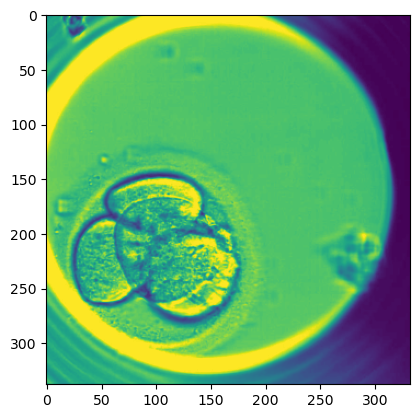

In [6]:

im_name=r'D:\images\tnia-python-images\imagesc\2024_06_10_cellpose_embryo\embryo.tif'
image = imread(im_name)
plt.imshow(image)

In [10]:
## Let's label it

label = np.zeros(image.shape, np.uint16)

import napari
viewer = napari.Viewer()
viewer.add_image(image)
viewer.add_labels(label)


C:\Users\bnort\AppData\Local\Temp\ipykernel_26044\4075124865.py:11: UserWarning: D:\images\tnia-python-images\imagesc\2024_06_10_cellpose_embryo\label.tif is a low contrast image
  imsave(r'D:\images\tnia-python-images\imagesc\2024_06_10_cellpose_embryo\label.tif', label)


In [11]:
from skimage.io import imsave
imsave(r'D:\images\tnia-python-images\imagesc\2024_06_10_cellpose_embryo\label.tif', label)

C:\Users\bnort\AppData\Local\Temp\ipykernel_26044\336746776.py:2: UserWarning: D:\images\tnia-python-images\imagesc\2024_06_10_cellpose_embryo\label.tif is a low contrast image
  imsave(r'D:\images\tnia-python-images\imagesc\2024_06_10_cellpose_embryo\label.tif', label)


In [15]:
truth = imread(r'D:\images\tnia-python-images\imagesc\2024_06_10_cellpose_embryo\label.tif')

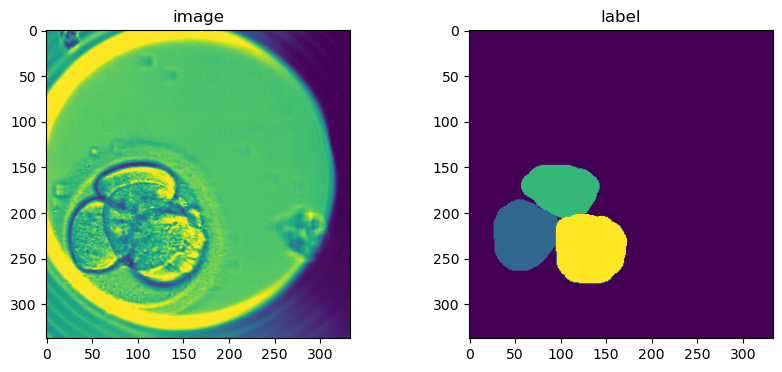

In [16]:
fig=imshow_multi2d([image, truth], ['image', 'label'], 1, 2)

## Load Cyto2

We also print the mean diameter of cyto2 (if log is on this will print by default too)

In [17]:
from cellpose import models, io
model_cyto2 = models.CellposeModel(gpu=True, model_type="cyto2")
print('cyto2 diameter mean', model_cyto2.diam_labels)

cyto2 diameter mean 30.0


## Process with different diameters and cyto2

We try 6, default (which was 30), and 140 (use the same diameters as our 2 objects)

It looks like d=6 finds the small object, d=140 finds the big one, and default finds only the small one. 

Note that the samll object is not the same size between d=6 and default. 

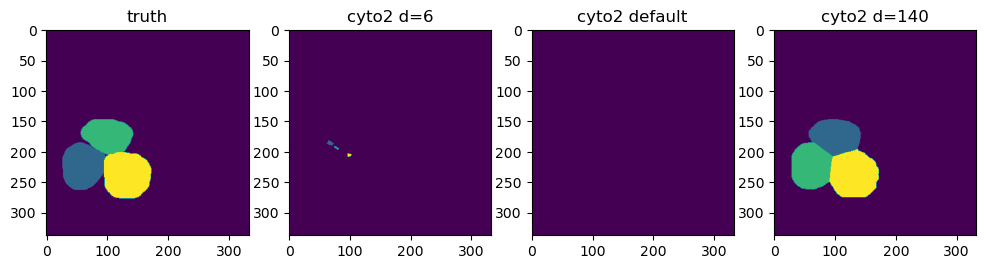

In [18]:
labels_d6 = model_cyto2.eval(truth, channels=[0, 0],diameter=6,flow_threshold=0.8, cellprob_threshold=-0.8)[0]
labels_default = model_cyto2.eval(truth, channels=[0, 0], flow_threshold=0.8, cellprob_threshold=-0.8)[0]
labels_d140 = model_cyto2.eval(truth, channels=[0, 0],diameter=140,flow_threshold=0.8, cellprob_threshold=-0.8)[0]
fig = imshow_multi2d([truth, labels_d6, labels_default, labels_d140], ['truth', 'cyto2 d=6', 'cyto2 default', 'cyto2 d=140'],1 ,4, width = 12, height = 6)


## Repeat the objects to make a fake training set

Just repeat a few times to make a trivial training set.  No need to even add blur or noise, we just want to see if a custom model can learn different scales. 

In [19]:
X = [image.copy().astype('float32')[..., np.newaxis] for i in range(10)]
Y = [truth.copy().astype('uint16') for i in range(10)]

## Make a custom model

In [28]:
import os

model_path = r'./'
model_name = 'custom'
logger = io.logger_setup()
model_custom = models.CellposeModel(gpu=True, model_type=None, pretrained_model=os.path.join(model_path,'models',model_name))
model_finetune = models.CellposeModel(model_type='cyto3', pretrained_model='cyto3')

creating new log file
2024-06-10 15:27:15,396 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2024-06-10 15:27:15,397 [INFO] 
cellpose version: 	2.2.3 
platform:       	win32 
python version: 	3.10.13 
torch version:  	2.1.2+cu118
2024-06-10 15:27:15,397 [INFO] >>>> loading model ./models\custom
2024-06-10 15:27:15,400 [INFO] ** TORCH CUDA version installed and working. **
2024-06-10 15:27:15,401 [INFO] >>>> using GPU
2024-06-10 15:27:15,644 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-06-10 15:27:15,646 [INFO] >>>> model diam_labels =  73.872 (mean diameter of training ROIs)
2024-06-10 15:27:15,651 [WARNING] pretrained model has incorrect path
2024-06-10 15:27:15,652 [INFO] >> cyto3 << model set to be used
2024-06-10 15:27:15,653 [INFO] Downloading: "https://www.cellpose.org/models/cyto3" to C:\Users\bnort\.cellpose\models\cyto3



100%|██████████| 25.3M/25.3M [00:01<00:00, 13.8MB/s]

2024-06-10 15:27:17,801 [INFO] >>>> using CPU


2024-06-10 15:27:17,954 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-06-10 15:27:17,955 [INFO] >>>> model diam_labels =  30.000 (mean diameter of training ROIs)


## Train our custom model

Note if the log is on it will report the average diameter or the training objects (which should be (6+140)/2=73)

In [29]:
test=model_finetune.train(X, Y, 
    channels=[0,0], 
    save_path=model_path, 
    n_epochs=80,
    nimg_per_epoch=10,
    min_train_masks=1,
    model_name='fine_tune')

2024-06-10 15:28:23,234 [INFO] computing flows for labels


100%|██████████| 10/10 [00:00<00:00, 13.50it/s]


2024-06-10 15:28:24,041 [INFO] >>>> median diameter set to = 30
2024-06-10 15:28:24,042 [INFO] >>>> mean of training label mask diameters (saved to model) 73.872
2024-06-10 15:28:24,042 [INFO] >>>> training network with 2 channel input <<<<
2024-06-10 15:28:24,043 [INFO] >>>> LR: 0.20000, batch_size: 8, weight_decay: 0.00001
2024-06-10 15:28:24,044 [INFO] >>>> ntrain = 10
2024-06-10 15:28:24,044 [INFO] >>>> nimg_per_epoch = 10
2024-06-10 15:28:26,532 [INFO] Epoch 0, Time  2.5s, Loss 0.5300, LR 0.0000
2024-06-10 15:28:28,922 [INFO] saving network parameters to ./models/fine_tune
2024-06-10 15:28:38,174 [INFO] Epoch 5, Time 14.1s, Loss 0.3368, LR 0.1111
2024-06-10 15:28:49,875 [INFO] Epoch 10, Time 25.8s, Loss 0.1680, LR 0.2000
2024-06-10 15:29:12,245 [INFO] Epoch 20, Time 48.2s, Loss 0.0823, LR 0.2000
2024-06-10 15:29:34,506 [INFO] Epoch 30, Time 70.5s, Loss 0.0526, LR 0.2000
2024-06-10 15:29:56,672 [INFO] Epoch 40, Time 92.6s, Loss 0.0473, LR 0.2000
2024-06-10 15:30:18,743 [INFO] Epoch

In [ ]:
test=model_custom.train(X, Y, 
    channels=[0,0], 
    save_path=model_path, 
    n_epochs=80,
    nimg_per_epoch=10,
    min_train_masks=1,
    model_name=model_name)

In [30]:
labels_custom = model_custom.eval(X[0][0,:,:], channels=[0, 0])[0]
labels_finetune= model_finetune.eval(X[0][0,:,:], channels=[0, 0])[0]

## Show all the cyto labels and label custom

Note, cyto can only find objects of different sizes by tuning the ```diameter``` param.  Custom can find very different object sizes by default. 

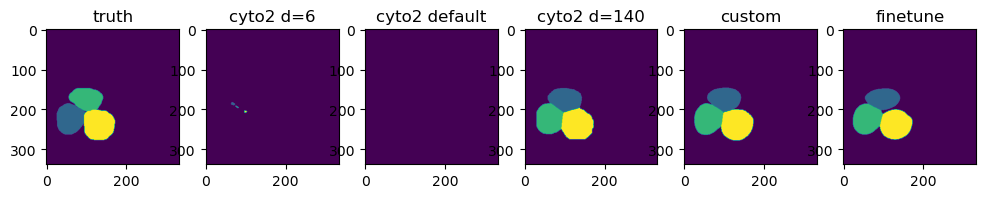

In [32]:
fig = imshow_multi2d([truth, labels_d6, labels_default, labels_d140, labels_custom, labels_finetune], ['truth', 'cyto2 d=6', 'cyto2 default', 'cyto2 d=140', 'custom', 'finetune'],1 ,6, width = 12, height = 6)

In [27]:
print(model_custom.diam_labels)
print(model_cyto2.diam_labels)

73.87221865312362
30.0
